# Analysis of CiDiff


## Imports and configuration

In [2]:
import numpy as np
import pandas as pd
import plotnine as pn
import mizani as mi
import mizani.transforms as tr
import statsmodels as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pn.theme_set(pn.theme_minimal())

print("Numpy: %s"%np.__version__)
print("Pandas: %s"%pd.__version__)
print("Plotnine: %s"%pn.__version__)
print("Mizani: %s"%mi.__version__)
print("statsmodels: %s"%sm.__version__)

Numpy: 2.2.2
Pandas: 2.2.3
Plotnine: 0.14.5
Mizani: 0.13.1
statsmodels: 0.14.4


In [3]:
def order(df, col):
    l = df[col].value_counts().index.to_list()
    l.reverse()
    c = pd.Categorical(df[col], categories=l)
    df[col] = c
    return df

In [4]:
DATASET_FILE = "./dataset.csv"
BENCHMARK_FILE = "./benchmark.csv"
SURVEY_FILE = "./survey.csv"
ANNOTATIONS_FILE = "./annotations.csv"

In [5]:
# lines_bins = [0, 100, 1000, 10000, 100000, float('inf')]
# lines_labels = ['0-100', '100-1K', '1K-10K', '10K-100K', '100K+']
lines_bins = [0, 1000, 5000, 10000, 50000, float('inf')]
lines_labels = ['0-1K', '1K-5K', '5K-10K', '10K-50K', '50K+']

## Dataset Analysis

In [6]:
dataset = pd.read_csv(DATASET_FILE, sep=',')
dataset["lines-all"] = dataset["success"] + dataset["failure"]
dataset['lines-all-bins'] = pd.cut(dataset['lines-all'], bins=lines_bins, labels=lines_labels, right=False, include_lowest=True)

dataset.head()

,repository,run,language,success,failure,lines-all,lines-all-bins
0,stimulusreflex/cable_ready,run456-0,Ruby,585,603,1188,1K-5K
1,stimulusreflex/cable_ready,run740-0,Ruby,579,498,1077,1K-5K
2,yogeshojha/rengine,run1445-0,JavaScript,62,67,129,0-1K
3,marcominerva/chatgptnet,run35-0,C#,740,750,1490,1K-5K
4,determinatesystems/nix-installer,run1008-0,Rust,929,550,1479,1K-5K


In [7]:
print(len(dataset))
print(len(set(dataset["repository"].to_list())))
print(len(set(dataset["language"].to_list())))

17906
7955
20


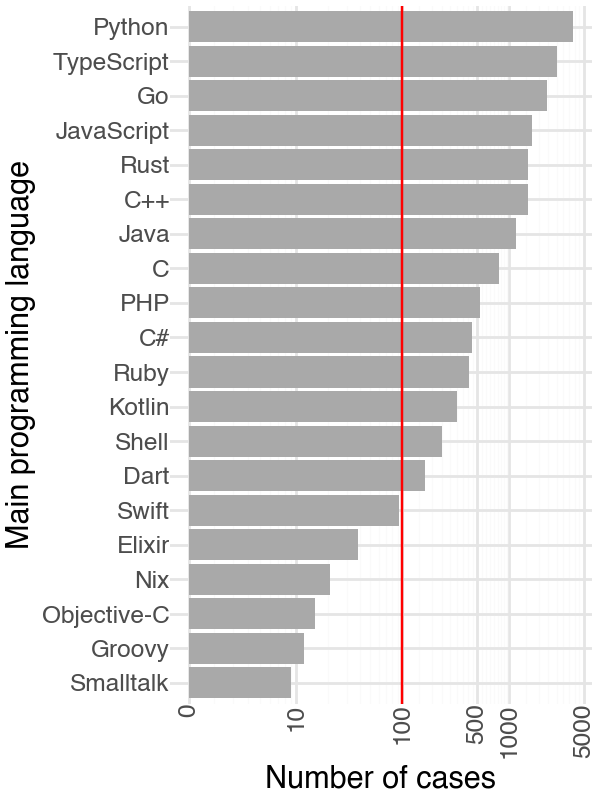

In [8]:
plot = pn.ggplot(dataset, pn.aes(x="language")) + pn.geom_bar(fill="darkgrey") + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 10, 100, 500, 1000, 5000]) + pn.xlab("Main programming language") + pn.ylab("Number of cases") + pn.geom_hline(yintercept=100, color="red") + pn.scale_x_discrete(limits=dataset['language'].value_counts().index.tolist()[::-1]) + pn.coord_flip() + pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(3, 4))
plot.save("img/main_language_per_case.pdf", verbose=False)
plot


In [9]:
dataset["language"].value_counts().to_frame()

,count
language,
Python,3930
TypeScript,2782
Go,2271
JavaScript,1653
Rust,1514
C++,1495
Java,1149
C,807
PHP,528


In [10]:
len(set(dataset["repository"].to_list()))

7955

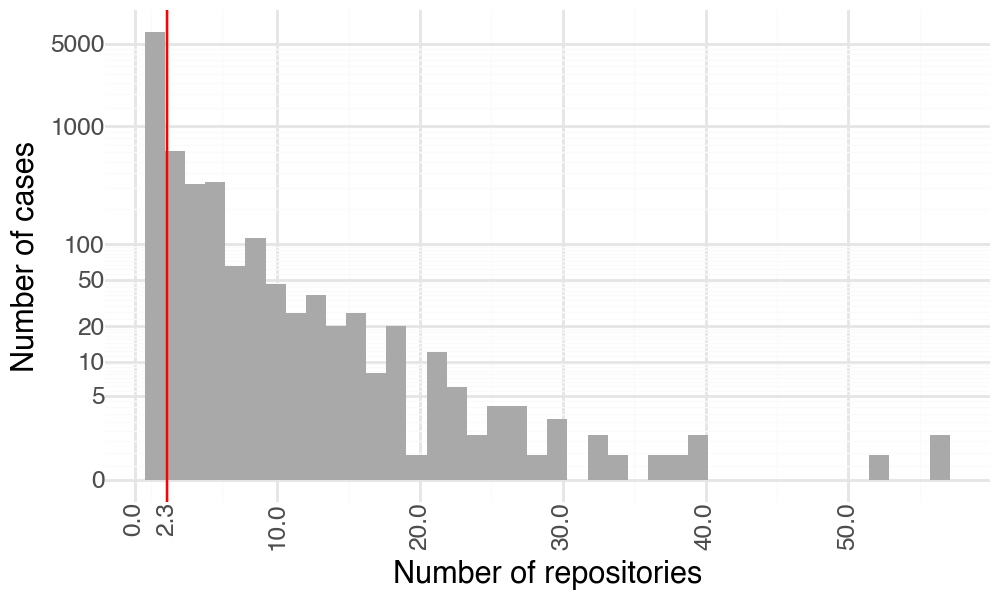

In [11]:
projects = dataset["repository"].value_counts().to_frame()
plot = pn.ggplot(projects, pn.aes(x="count")) + pn.geom_histogram(bins=40, fill="darkgrey") + pn.geom_vline(xintercept=projects["count"].mean(), color="red") + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 5, 10, 20,50, 100, 1000, 5000]) + pn.ylab("Number of cases") + pn.scale_x_continuous(breaks=[0, projects["count"].mean(), 10, 20, 30, 40, 50, 60]) +  pn.xlab("Number of repositories") + pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(5, 3))
plot.save("img/cases_per_project.pdf", verbose=False)
plot

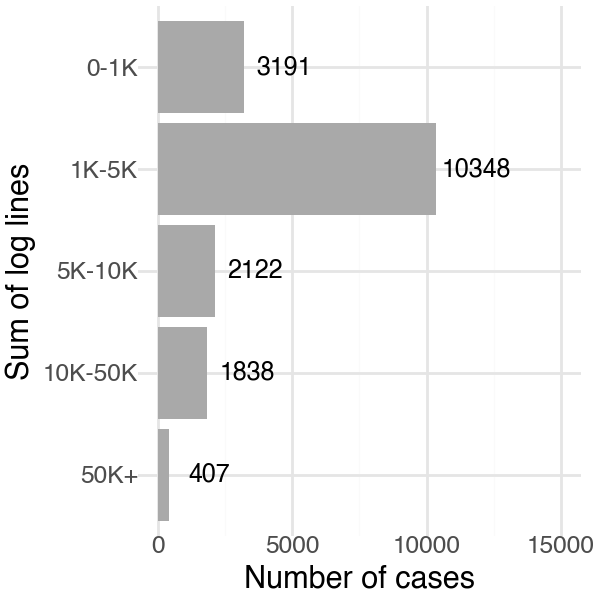

In [12]:

plot = pn.ggplot(dataset, pn.aes(x='lines-all-bins')) + pn.geom_bar(fill="darkgrey") + pn.geom_text(pn.aes(label=pn.after_stat("count")), stat="count", nudge_y=1500, size=9) + pn.xlab("Sum of log lines") + pn.ylim(0,15000) + pn.scale_x_discrete(limits=list(reversed(dataset['lines-all-bins'].cat.categories))) + pn.ylab("Number of cases") + pn.coord_flip() + pn.theme(figure_size=(3, 3))
plot.save("img/total_lines_per_case.pdf", verbose=False)
plot

## Benchmark Results Analysis

In [13]:
data = pd.read_csv(BENCHMARK_FILE, sep=',')
data["lines-all"] = data["lines-left"] + data["lines-right"]
data['lines-all-bins'] = pd.cut(data['lines-all'], bins=lines_bins, labels=lines_labels, right=False)
data.head()

,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,runs,lines-all,lines-all-bins
0,freecodecamp/freecodecamp/run608-0,seed,1.5,67,68,2,1,0,1,0,0,8,3,5,3,135,0-1K
1,freecodecamp/freecodecamp/run608-0,lcs,0.8,67,68,3,2,1,0,0,0,8,3,5,3,135,0-1K
2,freecodecamp/freecodecamp/run41367-0,lcs,3.8,1022,1045,337,180,157,0,0,0,136,69,67,3,2067,1K-5K
3,freecodecamp/freecodecamp/run41367-0,seed,18.7,1022,1045,191,34,11,126,20,0,141,71,70,3,2067,1K-5K
4,freecodecamp/mobile/run3037-0,seed,6.3,1170,1082,158,14,102,41,1,0,138,76,62,3,2252,1K-5K


In [14]:
REFERENCE_TYPE = "lcs"
ALTERNATE_TYPES = ["seed"]
REFERENCE_SUFFIX = "-" + REFERENCE_TYPE

In [15]:
data[data["duration"] == -1.0].groupby("type").count()["duration"].to_frame()

,duration
type,
lcs,21
seed,21


In [16]:
data[data["duration"] == -1.0]

,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,runs,lines-all,lines-all-bins
3140,playtika/feign-reactive/run215-0,seed,-1.0,473725,98173,0,0,0,0,0,0,0,0,0,0,571898,50K+
3141,playtika/feign-reactive/run215-0,lcs,-1.0,473725,98173,0,0,0,0,0,0,0,0,0,0,571898,50K+
3820,cyrusimap/cyrus-imapd/run2280-0,seed,-1.0,754437,756616,0,0,0,0,0,0,0,0,0,0,1511053,50K+
3821,cyrusimap/cyrus-imapd/run2280-0,lcs,-1.0,754437,756616,0,0,0,0,0,0,0,0,0,0,1511053,50K+
5530,oasislmf/oasislmf/run1709-0,lcs,-1.0,3318,1634236,0,0,0,0,0,0,0,0,0,0,1637554,50K+
5531,oasislmf/oasislmf/run1709-0,seed,-1.0,3318,1634236,0,0,0,0,0,0,0,0,0,0,1637554,50K+
7124,noobaa/noobaa-core/run5617-0,seed,-1.0,89668,75208,0,0,0,0,0,0,0,0,0,0,164876,50K+
7125,noobaa/noobaa-core/run5617-0,lcs,-1.0,89668,75208,0,0,0,0,0,0,0,0,0,0,164876,50K+
10468,NetEase/amoro/run2839-0,seed,-1.0,244247,253359,0,0,0,0,0,0,0,0,0,0,497606,50K+
10469,NetEase/amoro/run2839-0,lcs,-1.0,244247,253359,0,0,0,0,0,0,0,0,0,0,497606,50K+


In [17]:
print(set(data[data["duration"] == -1.0][data["type"] == "lcs"]["directory"].to_list()) - set(data[data["duration"] == -1.0][data["type"] == "seed"]["directory"].to_list()))
print(set(data[data["duration"] == -1.0][data["type"] == "seed"]["directory"].to_list()) - set(data[data["duration"] == -1.0][data["type"] == "lcs"]["directory"].to_list()))

set()
set()


/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_21342/1200980711.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_21342/1200980711.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_21342/1200980711.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_21342/1200980711.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [18]:
duration_bins = [-1.0, 0.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, float('inf')]
data['duration-bin'] = pd.cut(data['duration'], bins=duration_bins, labels=["timeout", "0-10ms", "10ms-100ms", "100ms-1s", "1s-10s", "10s-100s", "100s-10min"], include_lowest=True)
data['duration-bin'] = data['duration-bin'].cat.reorder_categories(['0-10ms', '10ms-100ms', '100ms-1s', '1s-10s','10s-100s', '100s-10min', 'timeout'], ordered=True)
data['duration-bin'].value_counts().to_frame()

,count
duration-bin,
0-10ms,20105
10ms-100ms,10597
100ms-1s,3088
1s-10s,1291
10s-100s,536
100s-10min,153
timeout,42


In [19]:
timeouts = set(data[data["duration"] == -1.0]["directory"].to_list())
paired_data = data[~data["directory"].isin(timeouts)]

ref_data = paired_data[paired_data["type"] == REFERENCE_TYPE][["directory", "duration", "actions", "added"]]
print(len(ref_data))

variant_data = paired_data[paired_data["type"].isin(ALTERNATE_TYPES)]
merged_data = variant_data.merge(ref_data, left_on="directory", right_on="directory", how="left", suffixes=["", REFERENCE_SUFFIX])

merged_data["duration-diff"] = 100 * (merged_data["duration"] - merged_data["duration" + REFERENCE_SUFFIX]) / (merged_data["duration" + REFERENCE_SUFFIX] + 1)

merged_data["duration-absdiff"] = merged_data["duration"] - merged_data["duration-lcs"]
                                                                        
merged_data["actions-diff"] = 100 * (merged_data["actions"] - merged_data["actions" + REFERENCE_SUFFIX]) / (merged_data["actions" + REFERENCE_SUFFIX] + 1)

merged_data["added-diff"] = 100 * (merged_data["added"] - merged_data["added" + REFERENCE_SUFFIX]) / (merged_data["added" + REFERENCE_SUFFIX] + 1) 

merged_data.head()


17885


,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,runs,lines-all,lines-all-bins,duration-bin,duration-lcs,actions-lcs,added-lcs,duration-diff,duration-absdiff,actions-diff,added-diff
0,freecodecamp/freecodecamp/run608-0,seed,1.5,67,68,2,1,0,1,0,0,8,3,5,3,135,0-1K,0-10ms,0.8,3,2,38.888889,0.7,-25.000000,-33.333333
1,freecodecamp/freecodecamp/run41367-0,seed,18.7,1022,1045,191,34,11,126,20,0,141,71,70,3,2067,1K-5K,10ms-100ms,3.8,337,180,310.416667,14.9,-43.195266,-80.662983
2,freecodecamp/mobile/run3037-0,seed,6.3,1170,1082,158,14,102,41,1,0,138,76,62,3,2252,1K-5K,0-10ms,15.3,200,56,-55.214724,-9.0,-20.895522,-73.684211
3,freecodecamp/developer_quiz_site/run1951-0,seed,5.2,457,468,36,17,6,13,0,0,58,29,29,3,925,0-1K,0-10ms,2.0,49,30,106.666667,3.2,-26.000000,-41.935484
4,freecodecamp/news-translation/run386-0,seed,8.9,501,456,368,4,49,315,0,0,38,19,19,3,957,0-1K,0-10ms,4.9,683,319,67.796610,4.0,-46.052632,-98.437500


In [20]:
merged_data.groupby("type")[["actions-diff","added-diff", "duration-diff"]].median()

,actions-diff,added-diff,duration-diff
type,,,
seed,-20.716846,-60.047562,16.666667


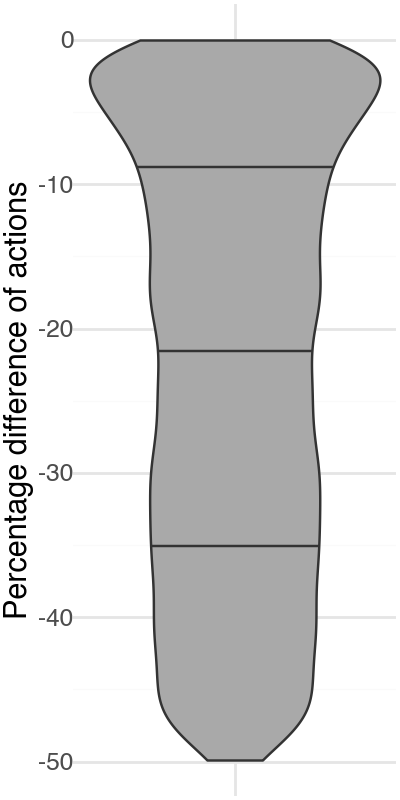

In [21]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="actions-diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.ylab("Percentage difference of actions") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank(), figure_size=(2,4))
plot.save("img/actions_diff.pdf", verbose=False)
plot

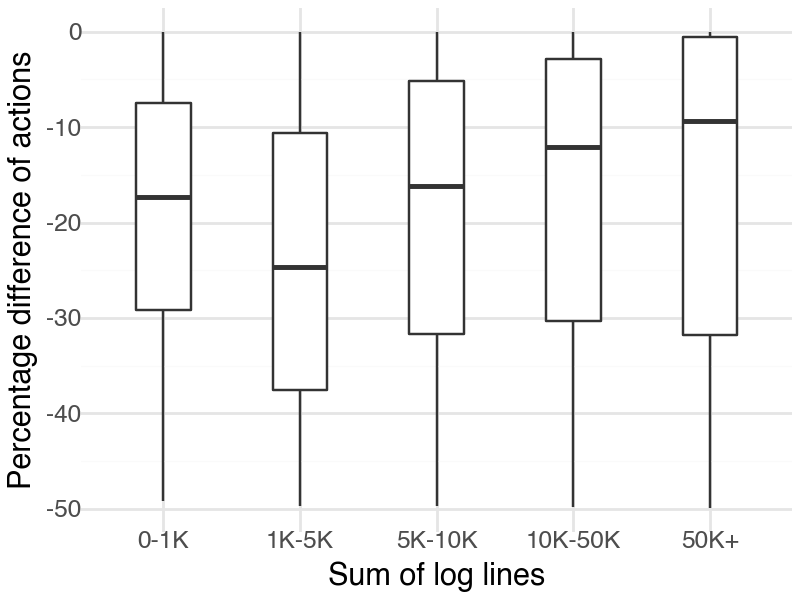

In [22]:
plot = pn.ggplot(merged_data, pn.aes(x='lines-all-bins', y='actions-diff')) + pn.geom_boxplot(width=0.4) + pn.xlab("Sum of log lines") + pn.ylab("Percentage difference of actions") + pn.theme(figure_size=(4,3))
plot.save("img/actions_diff_binned.pdf", verbose=False)
plot

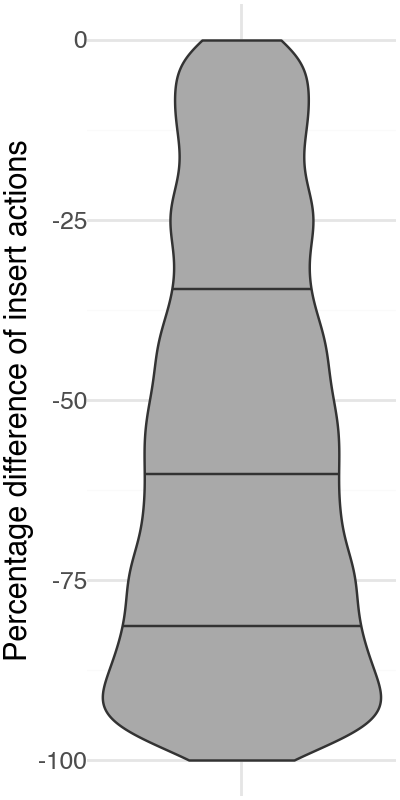

In [23]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="added-diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.ylab("Percentage difference of insert actions") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank(), figure_size=(2, 4))
plot.save("img/added_diff.pdf", verbose=False)
plot

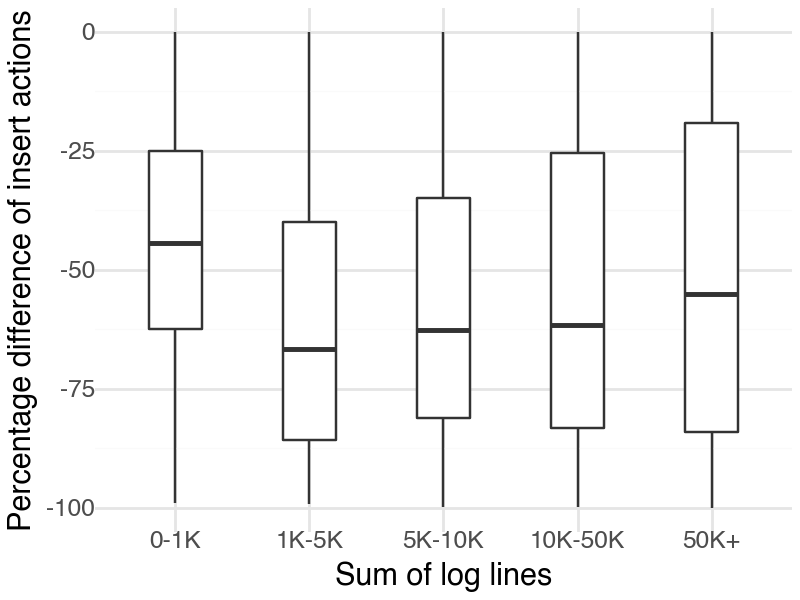

In [24]:
plot = pn.ggplot(merged_data, pn.aes(x='lines-all-bins', y='added-diff')) + pn.geom_boxplot(width=0.4) + pn.xlab("Sum of log lines") + pn.ylab("Percentage difference of insert actions") + pn.theme(figure_size=(4,3))
plot.save("img/added_diff_binned.pdf", verbose=False)
plot

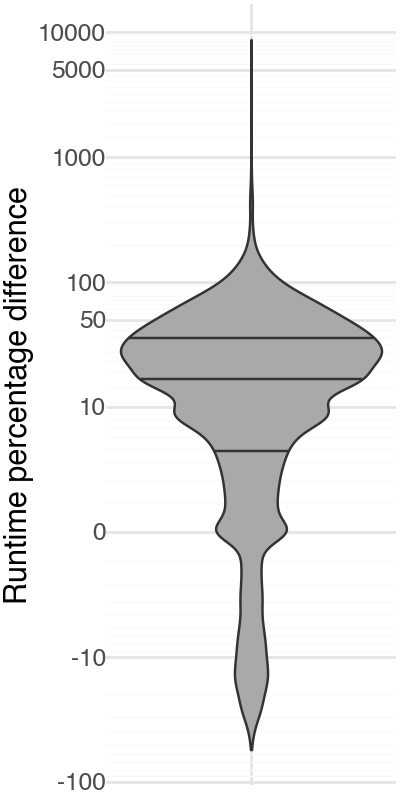

In [25]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="duration-diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[-100, -10, 0, 10, 50, 100, 1000, 5000, 10000]) + pn.ylab("Runtime percentage difference") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank(), figure_size=(2, 4))
plot.save("img/runtime_diff.pdf", verbose=False)
plot

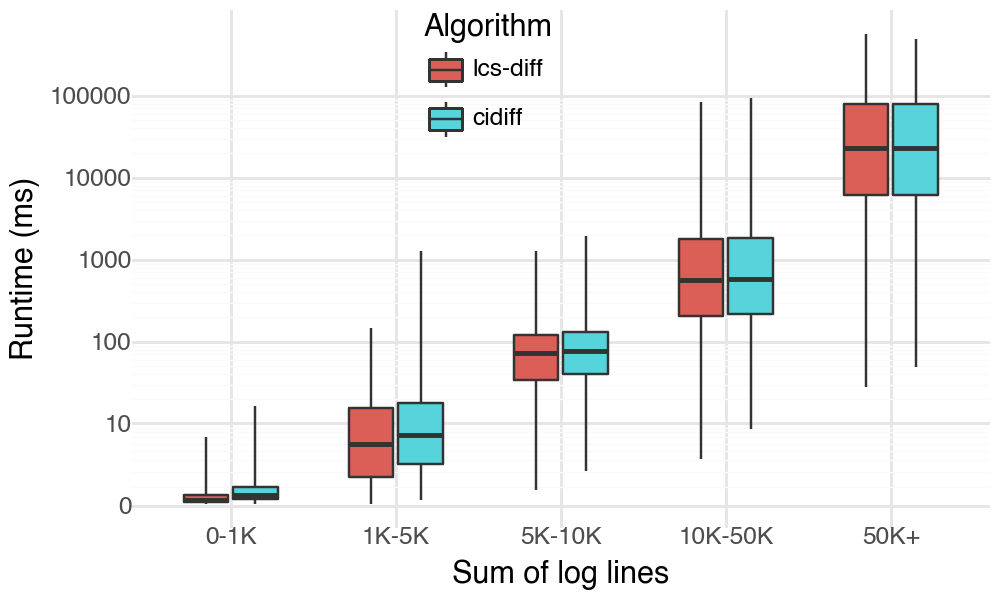

In [26]:
plot = pn.ggplot(paired_data, pn.aes(x='lines-all-bins', y='duration', fill='type')) + pn.geom_boxplot(coef=1000, width=0.6) + pn.xlab("Sum of log lines") + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 10, 100, 1000, 10000, 100000]) + pn.scale_fill_discrete(labels=["lcs-diff", "cidiff"], name="Algorithm") + pn.ylab("Runtime (ms)") +  pn.theme(figure_size=(5,3), legend_position=(0.4,1))
plot.save("img/runtimes_binned.pdf", verbose=False)
plot

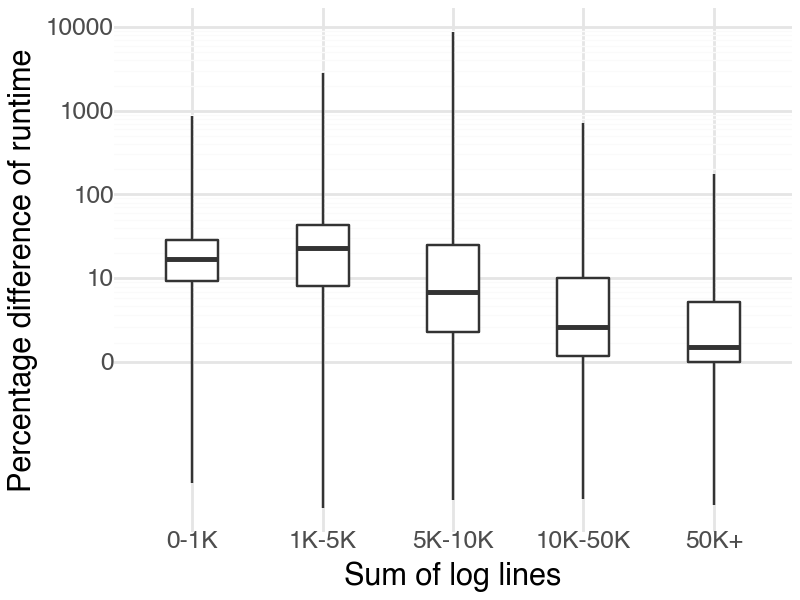

In [27]:
plot = pn.ggplot(merged_data, pn.aes(x='lines-all-bins', y='duration-diff')) + pn.geom_boxplot(width=0.4, coef=1000) + pn.xlab("Sum of log lines") + pn.ylab("Percentage difference of runtime") + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 10, 100, 1000, 10000, 100000]) + pn.theme(figure_size=(4,3))
# plot.save("img/added_diff_binned.pdf", verbose=False)
plot

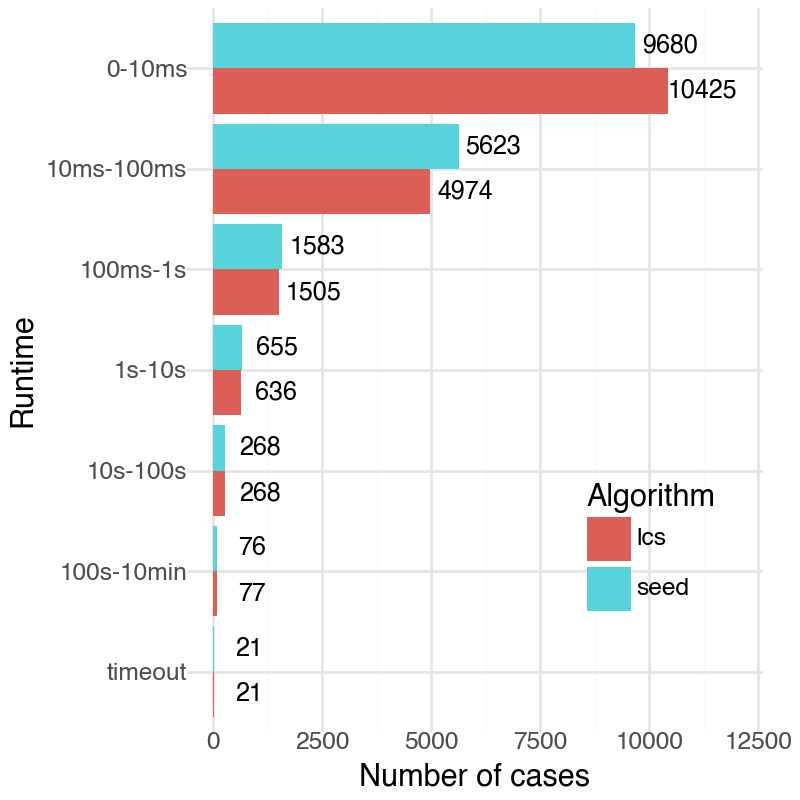

In [28]:
pn.ggplot(data, pn.aes(x="duration-bin", fill="type")) + pn.geom_bar(position="dodge") + pn.geom_text(pn.aes(label=pn.after_stat("count"), y=pn.stage(after_stat="count", after_scale="y + 800")), stat="count", position=pn.position_dodge2(width=0.9), size=9) + pn.scale_fill_discrete(name="Algorithm") + pn.scale_x_discrete(limits=list(reversed(data['duration-bin'].cat.categories))) + pn.ylim(0, 12000) + pn.coord_flip() + pn.xlab("Runtime") + pn.ylab("Number of cases") + pn.theme(figure_size=(4, 4), legend_position=(0.9,0.2))

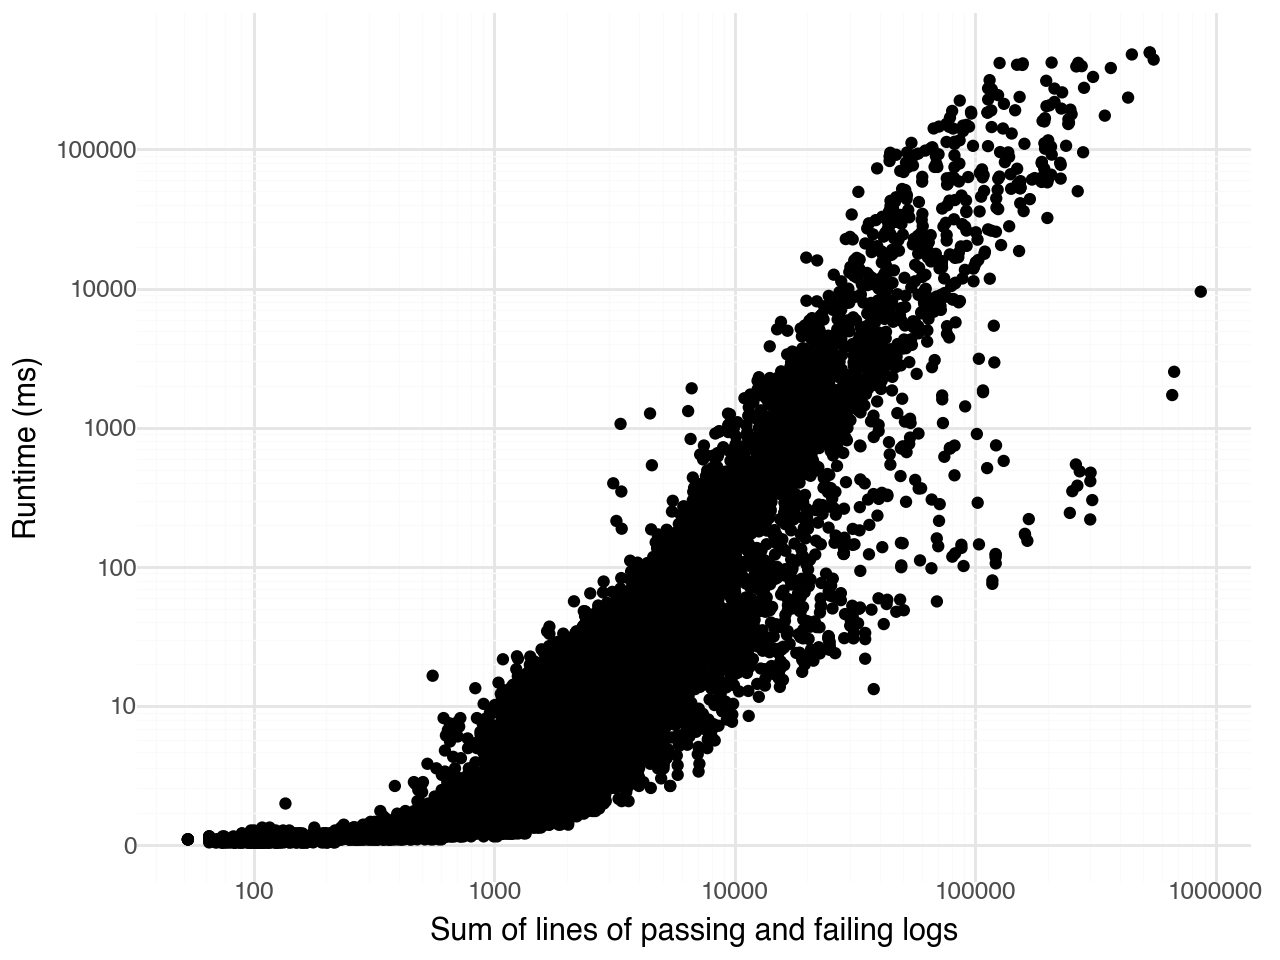

In [29]:
plot = pn.ggplot(merged_data, pn.aes(x="lines-all", y="duration")) + pn.geom_point() + pn.scale_x_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, -10, 100, 1000, 10000, 100000, 1000000]) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 10, 100, 1000, 10000, 100000]) + pn.xlab("Sum of lines of passing and failing logs") + pn.ylab("Runtime (ms)")
plot.save("img/runtimes.pdf", verbose=False)
plot

In [30]:
merged_data[merged_data["duration-diff"] > 1000]

,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,runs,lines-all,lines-all-bins,duration-bin,duration-lcs,actions-lcs,added-lcs,duration-diff,duration-absdiff,actions-diff,added-diff
644,utopia-rise/fmod-gdnative/run33-1,seed,1269.2,2264,2173,1400,99,190,430,16,665,257,140,117,3,4437,1K-5K,1s-10s,42.8,2511,1210,2800.000000,1226.4,-44.227707,-91.742362
647,utopia-rise/fmod-gdnative/run33-4,seed,1067.7,1777,1568,1392,176,385,462,61,308,958,477,481,3,3345,1K-5K,1s-10s,46.8,2223,1007,2135.774059,1020.9,-37.365108,-82.440476
650,utopia-rise/fmod-gdnative/run33-10,seed,399.6,1638,1481,1053,92,249,389,95,228,851,463,388,3,3119,1K-5K,100ms-1s,34.9,1765,804,1015.877437,364.7,-40.317101,-88.447205
6985,rickclephas/kmp-nativecoroutines/run282-0,seed,1923.8,3312,3298,1259,228,242,427,347,15,904,455,449,3,6610,5K-10K,1s-10s,45.7,2048,1017,4021.627409,1878.1,-38.506589,-77.504912
12152,netlify/netlify-cms/run1345-0,seed,1319.4,3202,3189,435,11,24,400,0,0,794,398,396,3,6391,5K-10K,1s-10s,13.9,835,411,8761.744966,1305.5,-47.846890,-97.087379


In [31]:
merged_data[merged_data["duration-absdiff"] > 10000]

,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,runs,lines-all,lines-all-bins,duration-bin,duration-lcs,actions-lcs,added-lcs,duration-diff,duration-absdiff,actions-diff,added-diff
1946,nashtech-garage/yas/run676-0,seed,94720.6,18407,25881,39544,22805,15331,1204,91,113,2473,1206,1267,1,44288,10K-50K,10s-100s,82411.1,40952,24213,14.936520,12309.5,-3.438088,-5.814818
2066,asynkronit/protoactor-go/run379-0,seed,481584.1,442156,5991,444135,3257,439422,1417,36,3,621,315,306,1,448147,50K+,100s-10min,440134.3,445591,4713,9.417513,41449.8,-0.326756,-30.886720
5490,splunk/splunk-operator/run1185-2,seed,394925.8,254110,9088,245979,309,245331,335,4,0,341,172,169,1,263198,50K+,100s-10min,367834.3,246318,648,7.365117,27091.5,-0.137626,-52.234206
5621,matrix-org/matrix-react-sdk/run21671-1,seed,91583.5,8289,38540,45169,37672,7421,73,3,0,2216,1109,1107,1,46829,10K-50K,10s-100s,73429.8,45245,37748,24.722187,18153.7,-0.167971,-0.201330
6450,timescale/timescaledb/run19393-0,seed,73148.5,12665,26392,33057,23127,9400,526,4,0,1325,670,655,2,39057,10K-50K,10s-100s,53882.6,33587,23657,35.754664,19265.9,-1.577945,-2.240257
8086,fisco-bcos/fisco-bcos/run1097-0,seed,74900.5,12350,55362,63774,53207,10195,224,130,18,1380,705,675,1,67712,50K+,10s-100s,56060.4,64146,53579,33.606189,18840.1,-0.579918,-0.694289
8198,tiledb-inc/tiledb-py/run5505-6,seed,164770.6,4140,239900,236452,235788,28,602,34,0,701,353,348,1,244040,50K+,100s-10min,121023.6,237088,236424,36.147197,43747.0,-0.268254,-0.269007
8381,nilfoundation/zkllvm/run57-0,seed,35524.5,31635,12102,28160,697,20230,664,439,6130,1917,969,948,3,43737,10K-50K,10s-100s,19585.3,35393,7930,81.379331,15939.2,-20.435667,-91.199092
8853,facebookincubator/mvfst/run4316-0,seed,109864.6,91093,69054,30741,576,22615,999,5768,783,6488,3313,3175,1,160147,50K+,100s-10min,39748.1,38291,8126,176.397705,70116.5,-19.716912,-92.900209
13851,openidentityplatform/opendj/run17-0,seed,25219.9,29767,29740,18260,3463,3490,5965,1555,3787,7984,3976,4008,3,59507,50K+,10s-100s,13604.2,29567,14770,85.376915,11615.7,-38.240666,-76.548643


## Survey Analysis

In [32]:
survey = pd.read_csv(SURVEY_FILE, sep=',')
survey.replace(to_replace={"alpha": "cidiff", "beta": "lcs-diff", "none": "none"}, inplace=True)
survey.head()

,id,side-by-side,summary,p1,p2,p3
0,bytedeco/javacpp-presets/run46-1,diff 0,none,none,none,none
1,netlify/netlify-plugin-nextjs/run4250-0,diff 1,none,none,none,cidiff
2,python-markdown/markdown/run641-7,diff 2,none,none,none,none
3,ufbx/ufbx/run1143-4,diff 3,cidiff,cidiff,none,cidiff
4,eliaskosunen/scnlib/run307-3,diff 4,none,none,none,none


In [33]:
ratios = pd.DataFrame({"p": survey["summary"].value_counts() / len(survey)}).reset_index()
ratios["p_min"] = np.maximum(ratios["p"] - 0.10, 0)
ratios["p_max"] = np.minimum(ratios["p"] + 0.10, 1)

ratios

,summary,p,p_min,p_max
0,cidiff,0.70,0.60,0.80
1,none,0.25,0.15,0.35
2,lcs-diff,0.05,0.00,0.15


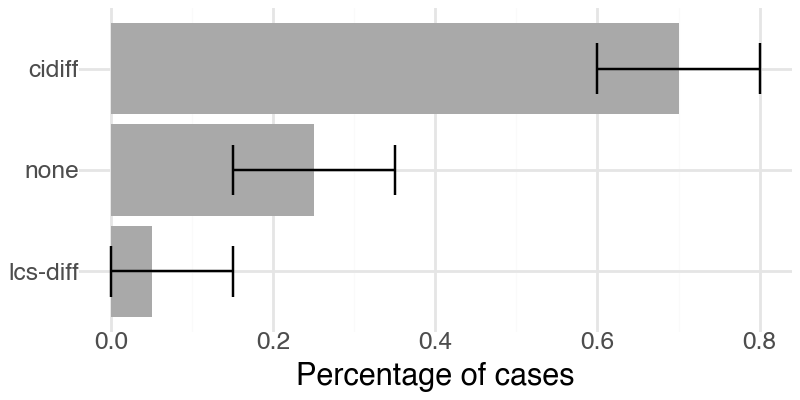

In [34]:
plot = pn.ggplot(ratios, pn.aes(x="summary", y="p")) + pn.geom_bar(stat="identity", fill="darkgrey") + pn.geom_errorbar(pn.aes(ymin="p_min", ymax="p_max")) + pn.ylab("Percentage of cases") + pn.xlab("") + pn.coord_flip() + pn.scale_x_discrete(limits=['lcs-diff', 'none', 'cidiff']) + pn.theme(figure_size=(4, 2))
plot.save("img/survey.pdf", verbose=False) 
plot

In [35]:
ratings = survey[["p1", "p2", "p3"]]
ratings["none"] = (ratings[["p1", "p2", "p3"]] == "none").sum(axis=1)
ratings["cidiff"] = (ratings[["p1", "p2", "p3"]] == "cidiff").sum(axis=1)
ratings["lcs-diff"] = (ratings[["p1", "p2", "p3"]] == "lcs-diff").sum(axis=1)

final_ratings = ratings[["none", "cidiff", "lcs-diff"]]

sm.stats.inter_rater.fleiss_kappa(final_ratings, method="fleiss")

/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_21342/484290630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_21342/484290630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


np.float64(0.24551386623164734)

In [36]:
survey[survey["summary"] == "lcs-diff"]

,id,side-by-side,summary,p1,p2,p3
72,kreneskyp/ix/run573-0,diff 72,lcs-diff,cidiff,lcs-diff,lcs-diff
75,apollographql/apollo-client-nextjs/run24-0,diff 75,lcs-diff,cidiff,lcs-diff,lcs-diff
82,npm/ini/run266-17,diff 82,lcs-diff,cidiff,lcs-diff,lcs-diff
84,flathunters/flathunter/run634-0,diff 84,lcs-diff,cidiff,lcs-diff,lcs-diff
89,mohsenabrishami/stethoscope/run554-0,diff 89,lcs-diff,cidiff,lcs-diff,lcs-diff


## Accuracy analysis

In [78]:
def precs_and_recs(data, ref, algorithms=None):
    grouped = data.groupby(["path","type"])["line"].apply(set)
    values = []
    if algorithms is None:
        algorithms = set(data['type'].to_list()) - set([ref])
    for path in set([path for (path, _) in grouped.keys()]):
        ref_lines = grouped[path][ref]
        for alg in algorithms:
            if grouped[path].get(alg) is None:
                values.append([path, alg, 0.0, 0.0])
                continue

            alg_lines = grouped[path][alg]
            common_lines = ref_lines & alg_lines
            recall = len(common_lines) / len(ref_lines)
            precision = len(common_lines) / len(alg_lines)
            values.append([path, alg, precision, recall])

    return pd.DataFrame(values, columns=['path', 'algorithm', 'precision', 'recall'])

In [79]:
algorithms = ['bigram-raw', 'lcs', 'seed', 'keyword', '']
accuracies = precs_and_recs(pd.read_csv(ANNOTATIONS_FILE), 'human')
accuracies['f1-score'] = 2 * ((accuracies['precision'] * accuracies['recall']) / (accuracies['precision'] + accuracies['recall']))
accuracies['f1-score'] = accuracies['f1-score'].fillna(0)
legends = ['bigram (s2kdiff)', 'keyword', 'lcs-diff', 'cidiff']
accuracies.head()

,path,algorithm,precision,recall,f1-score
0,es-community/nsecure/run350-2,gpt,0.666667,0.108108,0.186047
1,es-community/nsecure/run350-2,bigram,0.145833,0.945946,0.252708
2,es-community/nsecure/run350-2,cidiff-drainsim,0.571429,0.648649,0.607595
3,es-community/nsecure/run350-2,lcs-diff,0.267327,0.729730,0.391304
4,es-community/nsecure/run350-2,keyword,0.416667,0.270270,0.327869


In [80]:
accuracies.groupby('algorithm')[['precision', 'recall', 'f1-score']].mean()

,precision,recall,f1-score
algorithm,,,
bigram,0.123396,0.969825,0.191240
bigram-drain,0.259826,0.963955,0.364273
cidiff,0.465967,0.911393,0.551315
cidiff-drainsim,0.458017,0.916606,0.544385
gpt,0.873301,0.460418,0.545361
keyword,0.684046,0.412902,0.450668
lcs-diff,0.211135,0.932429,0.292807


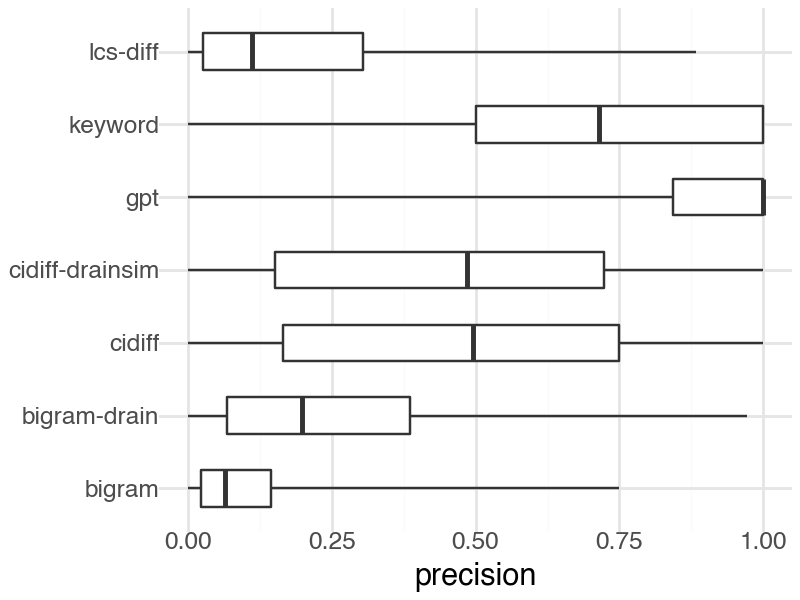

In [81]:
plot = pn.ggplot(accuracies, pn.aes(x='algorithm', y='precision')) + pn.geom_boxplot(width=0.5, coef=1000) + pn.scale_x_discrete() + pn.xlab('')  + pn.theme(figure_size=(4,3)) + pn.coord_flip()
plot.save('img/precisions.pdf', verbose=False)
plot

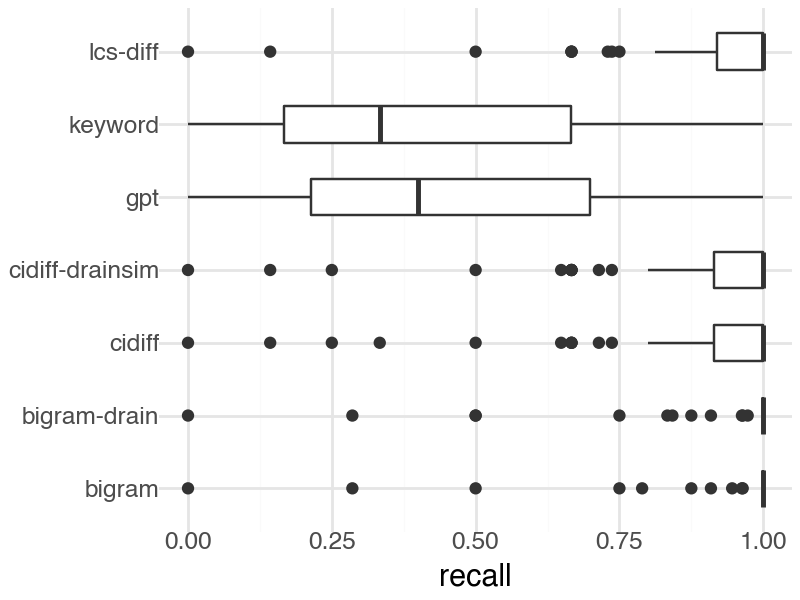

In [82]:
plot = pn.ggplot(accuracies, pn.aes(x='algorithm', y='recall')) + pn.geom_boxplot(width=0.5) + pn.xlab('') + pn.scale_x_discrete() + pn.theme(figure_size=(4,3)) + pn.coord_flip()
plot.save('img/recalls.pdf', verbose=False)
plot

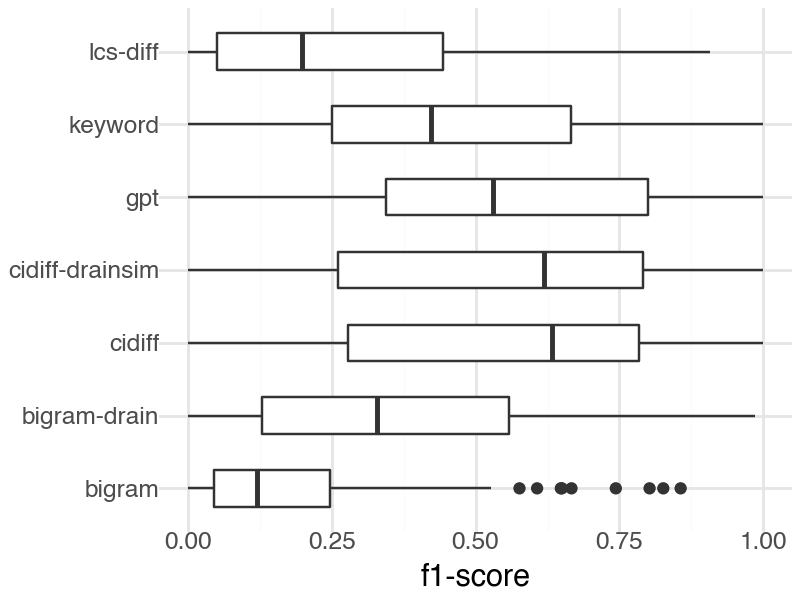

In [83]:
plot = pn.ggplot(accuracies, pn.aes(x='algorithm', y='f1-score')) + pn.geom_boxplot(width=0.5) + pn.xlab('') + pn.scale_x_discrete() + pn.theme(figure_size=(4,3)) + pn.coord_flip()
plot.save('img/f1-scores.pdf', verbose=False)
plot